In [58]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io as sio
import torch
import time

In [96]:
class EnsemblePursuit():
    def __init__(self):
        self.nr_of_ensembles=None
        self.current_v=np.zeros(1)
        self.current_u=np.zeros(1)
        self.U=np.zeros(1)
        self.V=np.zeros(1)
        
    def calculate_cost_delta(self):
        #print(np.dot(self.current_v.T,self.current_v))
        cost_delta=np.clip(self.current_v.T@self.X,0,None)/np.dot(self.current_v.T,self.current_v)[0]-self.lambd
        cost_delta=cost_delta.reshape(self.X.shape[1],1)
        return cost_delta
    
    def fit_one_assembly(self):
        #Have to figure out a good initialization
        choose_neuron_idx=np.random.randint(0,self.X.shape[1],1)
        self.current_u=np.zeros((self.X.shape[1],1))
        self.current_u[choose_neuron_idx,0]=1
        self.current_v=self.X[:,choose_neuron_idx]
        max_delta_cost=1000
        self.i=0
        while max_delta_cost>0:
            cost_delta=self.calculate_cost_delta()
            excl_ind=np.where(self.current_u.flatten()==1)[0]
            masked_cost_delta=np.ma.array(cost_delta,mask=self.current_u)
            max_delta_neuron=np.ma.argmax(masked_cost_delta,fill_value=-1000)
            max_delta_cost=cost_delta[max_delta_neuron]
            if max_delta_cost>0:
                self.current_v=(self.current_v+self.X[:,max_delta_neuron].reshape(self.X.shape[0],1))/2
                self.current_u[max_delta_neuron,0]=1
            self.i+=1
        self.U=np.hstack((self.U,self.current_u))
        self.V=np.vstack((self.V,self.current_v.T))
        
    #def plot_heatmaps(self):
        
        
    def fit_transform(self,X,lambd,n_ensembles=None):
        self.X=[]
        self.X=X
        #print(self.X.shape)
        self.lambd=lambd
        self.U=np.zeros((self.X.shape[1],1))
        self.V=np.zeros((1,self.X.shape[0]))
        self.nr_of_neurons=[]
        for iteration in range(0,n_ensembles):
            self.fit_one_assembly()
            self.nr_of_neurons.append(self.i)
            self.X=(self.X.T-self.current_u@self.current_v.T).T
            #Reset u for new iteration
            self.current_u=np.zeros((self.X.shape[1],1))
        self.U=self.U[:,1:]
        self.V=self.V[1:,:]
        return (self.U@self.V).T, self.nr_of_neurons, self.U, self.V
    

In [80]:
X=sio.loadmat('/home/maria/Documents/EnsemblePursuit/data/natimg2800_M170717_MP034_2017-09-11.mat')['stim']['resp'][0][0]
print(X.shape)
X[X<0]=0
stim=sio.loadmat('/home/maria/Documents/EnsemblePursuit/data/natimg2800_M170717_MP034_2017-09-11.mat')['stim']['istim'][0][0]

(5880, 10103)


In [27]:
np.random.seed(7)
ep=EnsemblePursuit()
ep.fit_transform(X,0.5,10)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [70]:
np.random.seed(7)
import cProfile
ep=EnsemblePursuit()
cProfile.run('ep.fit_transform(X,0.5,10)')

26
47
25
13
4
9
12
11
18
3
(11449, 11)
(11, 5426)
         11124 function calls in 9.872 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       10    0.022    0.002    5.361    0.536 <ipython-input-68-472ca1030b7c>:15(fit_one_assembly)
        1    4.511    4.511    9.872    9.872 <ipython-input-68-472ca1030b7c>:40(fit_transform)
      168    5.241    0.031    5.255    0.031 <ipython-input-68-472ca1030b7c>:9(calculate_cost_delta)
        1    0.000    0.000    9.872    9.872 <string>:1(<module>)
      168    0.000    0.000    0.004    0.000 _methods.py:37(_any)
      168    0.000    0.000    0.001    0.000 core.py:1360(getmask)
      168    0.005    0.000    0.034    0.000 core.py:2771(__new__)
      168    0.003    0.000    0.006    0.000 core.py:2908(_update_from)
      168    0.008    0.000    0.016    0.000 core.py:2934(__array_finalize__)
      840    0.003    0.000    0.003    0.000 core.py:3372(__setattr__)
      168

In [81]:
def test_train_split(data,stim):
    unique, counts = np.unique(stim.flatten(), return_counts=True)
    count_dict=dict(zip(unique, counts))

    keys_with_enough_data=[]
    for key in count_dict.keys():
        if count_dict[key]==2:
            keys_with_enough_data.append(key)

    filtered_stims=np.isin(stim.flatten(),keys_with_enough_data)

    #Arrange data so that responses with the same stimulus are adjacent
    z=stim.flatten()[np.where(filtered_stims)[0]]
    sortd=np.argsort(z)
    istim=np.sort(z)
    X=data[filtered_stims,:]
    out=X[sortd,:].copy()

    x_train=out[::2,:]
    y_train=istim[::2]
    x_test=out[1::2,:]
    y_test=istim[1::2]
    
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test=test_train_split(X,stim)
print(x_train.shape,x_test.shape)

(2800, 10103) (2800, 10103)


In [100]:
def correlate_train_test(fit_x_train,x_test):
    corr_coeff_lst=[]
    for j in range(0,fit_x_train.shape[1]):
        for i in range(0,x_test.shape[1]):
            if i==j:
                corr_coeff_lst.append(np.corrcoef(fit_x_train[:,j].T,x_test[:,i].T)[0,1])
    corr_coeff_lst=np.nan_to_num(corr_coeff_lst)
    return corr_coeff_lst

/home/maria/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


0.14805615909823153


(array([1028., 2788., 2400., 1804., 1059.,  618.,  258.,  105.,   36.,
           7.]),
 array([-0.03538023,  0.03069931,  0.09677886,  0.1628584 ,  0.22893794,
         0.29501748,  0.36109702,  0.42717656,  0.4932561 ,  0.55933564,
         0.62541518]),
 <a list of 10 Patch objects>)

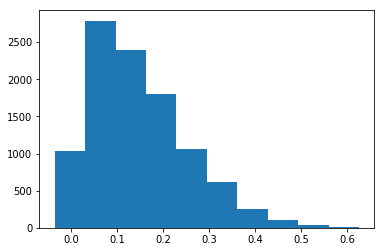

In [101]:
corr_coef=correlate_train_test(x_train,x_test)
#print(corr_coef)
corr_coef=np.nan_to_num(corr_coef)
print(np.mean(corr_coef))
plt.hist(corr_coef)

100 0.3 2634.534904241562


/home/maria/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/maria/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


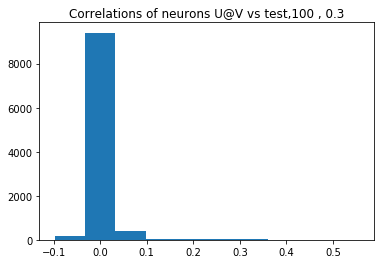

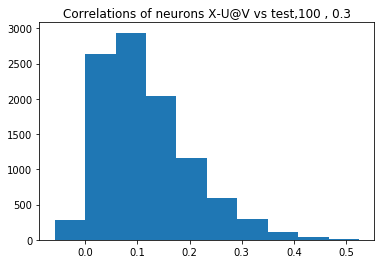

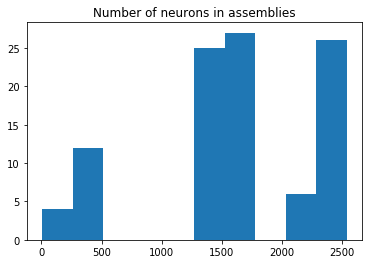

100 0.4 165.48084449768066


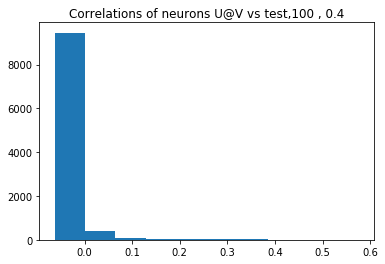

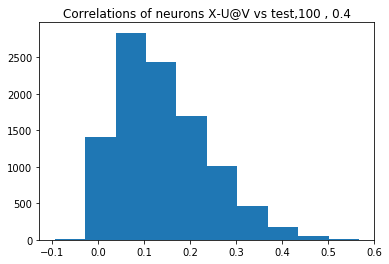

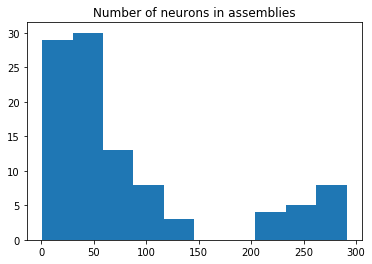

100 0.5 36.961392641067505


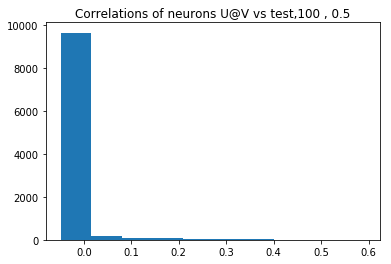

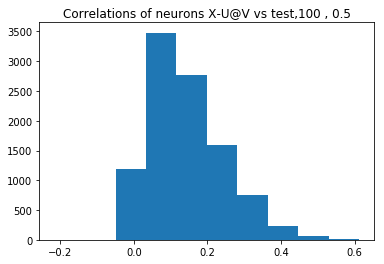

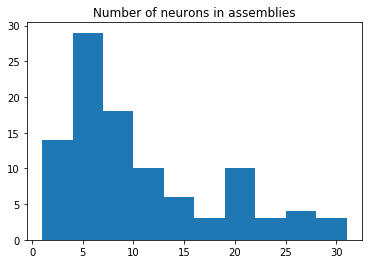

KeyboardInterrupt: 

In [98]:
n_ensembles=[100,200,300,400,500,600,700,800,900,1000]
lambdas=[0.3,0.4,0.5]

%matplotlib inline

fit_time_lst=[]
for n in n_ensembles:
    for l in lambdas:
        ep1=EnsemblePursuit()
        s=time.time()
        fit_x_train, n_of_neurons, U, V=ep1.fit_transform(x_train,l,n)
        e=time.time()
        np.save('U@V'+str(n)+'_'+str(l)+'.npy',fit_x_train)
        np.save('U'+str(n)+'_'+str(l)+'.npy',U)
        np.save('V'+str(n)+'_'+str(l)+'.npy',V)
        np.save('n_of_neurons'+str(n)+'_'+str(l)+'.npy',n_of_neurons)
        print(n,l,e-s)
        fit_time_lst.append(e-s)
        corr_lst=correlate_train_test(fit_x_train,x_test)
        corr_lst_sub=correlate_train_test(x_train-fit_x_train,x_test)
        plt.hist(corr_lst)
        plt.title('Correlations of neurons U@V vs test,'+str(n)+' , '+str(l))
        plt.show()
        plt.hist(corr_lst_sub)
        plt.title('Correlations of neurons X-U@V vs test,'+str(n)+' , '+str(l))
        plt.show()
        plt.hist(n_of_neurons)
        plt.title('Number of neurons in assemblies')
        plt.show()
np.save('times.npy',fit_time_lst)